## NWM Notebook 2: Mapping and Xarray

<strong><em>Created by <a href="https://www.linkedin.com/in/justin-hunter-0b86871a6/" target="_blank">Justin Hunter</a>, <a href="https://www.linkedin.com/in/danames/" target="_blank">Dr. Dan Ames</a>, and <a href="https://www.linkedin.com/in/easton-perkins-02968a156/" target="_blank">Easton Perkins</a> in collaboration with <a href="https://www.cuahsi.org" target="_blank">CUAHSI</a>.</em></strong><br>
<em><strong>2022. Brigham Young University. Provo, Utah.
<a href="https://hydroinformatics.byu.edu" target="_blank">BYU Hydroinformatics Lab</a>.</em></strong>

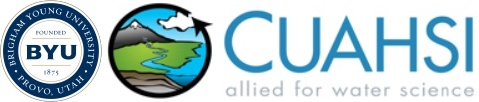

In this Jupyter Notebook we will take a look at  a NetCDF (Network Common Data Form) file from the National Water Model (NWM) using a Python package called xarray. NetCDF files are a standardized way of exchanging scientific data. NetCDF is well suited for multidimensional datasets containing meteorological or observational data such as NWM forecasts. NetCDF can also contain a lot of useful metadata. Xarray is a Python package which is built on NumPy and pandas and works well with NetCDF. We will also explore more ways to visualize the national water model and learn a couple different ways to display its reaches on a map. It is important to note that if you have opened this notebook in the CUAHSI JupyterHub environment that your available storage is limited. For that reason, this notebook includes code cells that will erase the downloaded forecast files to preserve space. The code deletes files in your Jupyter File Browser containing "nwm" and ".nc".  If you have .nc nwm forecast files that you wish to preserve, move them into a folder or rename them. You could also choose not to run these code cells and opt to manually manage your space. Be aware that some of the functions in this notebook may not be able to download all of the necessary .nc files to build a time series for a forecast if there isn't enough available storage space. It is usually simplest to delete any forecast files that you don't need.

<em><h4>Imports</h4></em>

The next cell installs or imports some Python modules or packages that will be used in this notebook. The functions and code in this notebook depend on these packages. If significant changes are made to a package it could affect the functionality of this notebook. The package version numbers originally used for some of the packages are included below along with a brief explanation of what each package will be used for.
* xarray makes it easier to work with multidimensional datasets like the NWM forecasts. (0.2.1)
* Importing the date type from the datetime module allows us to call todays date. 
* The os module allows us to communicate with the operating system. 
* Pandas is a useful library for data manipulation and analysis. (1.4.0)
* ipywidgets will be used to create a dropdown menu from which you can select a forecast type. (7.6.5)
* The requests module lets us make requests to web pages. (2.27.1)
* Matplotlib will help us create plots.
* ipyleaflet is a package for creating interactive maps in Python. (0.15.0)

In [ ]:
import xarray as xr
from datetime import date
import os
import pandas as pd
import ipywidgets as widgets

import requests
from requests import Request

import matplotlib.pyplot as plt
%matplotlib inline

import ipyleaflet
from ipyleaflet import Map, WMSLayer, basemaps, LayersControl

<em><h4>Functions</em></h4>

This next cell should look familiar! It defines the functions that were used in the first sandbox. These functions build the appropriate url for a NWM forecast, get the NetCDF file stored at that url, and then build a time series of data for a given reach or stream. Remember, these forecasts are being retrieved from the NOAA NWM file server located at https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/.

In [ ]:
def GetForecastFileName(ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1', TimeStep = '001'):
  BaseName = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.'

  ForecastStartDate

  if (ForecastType == 'short_range'):
    return BaseName + ForecastStartDate + '/short_range/nwm.t' + ForecastStartTimestep +'z.short_range.channel_rt.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'medium_range'): 
    return BaseName + ForecastStartDate + '/medium_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.medium_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'long_range'):
    return BaseName + ForecastStartDate + '/long_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.long_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  else:
    return 'error'

def GetForecastFile(Url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  FileName = os.path.basename(Url)
  if os.path.exists(FileName):
    os.remove(FileName)
  r = requests.get(Url, allow_redirects=True)
  open(FileName, 'wb').write(r.content)
  return FileName

def GetSeries(StreamID = 23275226, ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1'):
  TimeSteps = []
  TimeSteps.clear()
  Series = []
  Series.clear()
  if (ForecastType=='short_range'):
    for i in range(18):
      TimeSteps.append("%03d" % (i+1))
  elif (ForecastType=='medium_range' and ForecastMember=='1'):
    for i in range(80):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='medium_range' and ForecastMember!='1'):
    for i in range (68):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='long_range'):
    for i in range(120):
      TimeSteps.append("%03d" % ((i+1)*6))
  else: 
    return 'Error building time steps'
  
  for ts in TimeSteps:
    MyUrl = GetForecastFileName(ForecastStartDate,ForecastStartTimestep, ForecastType,ForecastMember,ts)
    FileName = GetForecastFile(MyUrl)
    if(FileName != 'error'):
      data = xr.open_dataset(FileName)
      Q = float(data.sel(feature_id=StreamID).streamflow.values)
      Series.append(Q)
    else:
      print('Error getting forecast files.')
    
  return Series

<em><h4>Variables</em></h4>

Next let's define some variables that we can use to download a forecast of our choice. Then we'll get the url and download the corresponding NetCDF forecast file.

In [ ]:
# These variables should look familiar to you from the first NWM notebook
ForecastStart = '00'
Type = 'short_range'
Member = '1'
Timestep = '001'
today = date.today()
today = str(today)
today = today.replace("-", "")
print(today)

# Build forecast url and get forecast file using the previously defined functions
url = GetForecastFileName(today, ForecastStart,Type,Member,Timestep)
path = GetForecastFile(url)

The next cell creates a variable called 'ds' and assigns it a value of the given NetCDF file opened as an xarray dataset. That file was called in using a variable called 'path' which was defined in the previous cell. Take a look at the output of the next cell and try to learn a little bit about the metadata included with this dataset. You'll be able to see the different dataset dimensions, coordinates, variables, and attributes of the dataset.

<em><h4>xarray</em></h4>

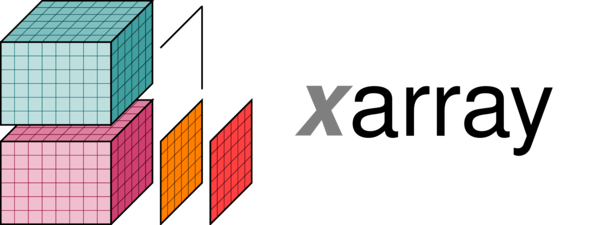

In [ ]:
# Open the NWM NetCDF file as an xarray dataset
ds = xr.open_dataset(path)
type(ds)
ds

In [ ]:
ds.feature_id.head()

Xarray has many useful options for dissecting and analyzing large multidimensional datasets such as NWM forecasts. It has great metadata support and is usually the best option when working with NetCDF. With xarray you're usually working with xarray datasets and datarrays. These are similar to pandas dataframes and dataseries but are better suited for multimdimensional data. The next few cells will walk you through a few things that xarray can do. For more information about xarray visit: http://xarray.pydata.org/en/stable/index.html.

The image below is an example of a multidimensional dataset. Each cube inside of the large cube represents a single olympic medal. Each one of these medals belongs to one of three medal types (gold, silver, or bronze), as well as to one country (USA, China, or Great Britain), and the year in which the medal was won (2004, 2008, 2012). These 3 dimensions help describe each piece of data or each medal in the dataset.
<br>
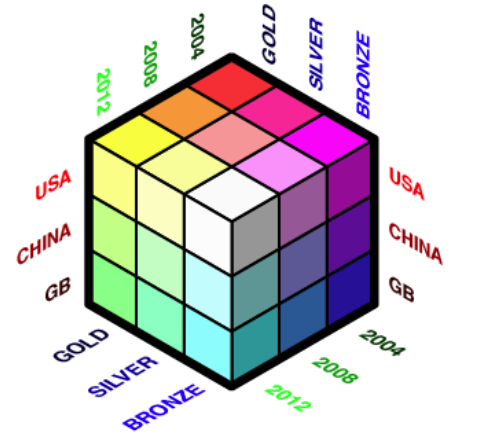


NWM forecasts are multidimensional datasets as well. They consist of variables or data with 3 dimensions and many attributes. Let's take a closer look at the way these forecasts are organized and what sort of things we can do with them in Python.

In [ ]:
# Let's separate out the variables of our dataset into a dictionary of corresponding DataArray objects.
vars_dict = ds.data_vars
print(vars_dict)
type(vars_dict)

In [ ]:
# You can also separate out the coordinates of the dataset into a dictionary of corresponding DataArray objects.
coords_dict = ds.coords
print(coords_dict)
type(coords_dict)

In [ ]:
# And you can separate out the attributes of a dataset into a dictionary of corresponding DataArray objects.
attrs_dict = ds.attrs
print(attrs_dict)
type(attrs_dict)

In [ ]:
# Now let's extract the streamflow values from the dataset as a dataarray
da = ds["streamflow"]
print(type(da))
print(da)

# How many streamflow values are there?
len(da)

In [ ]:
# Now let's try sorting the streamflow values in descending order and then dropping any null values. Now we can see the array is sorted from largest streamflow value to smallest.
da = da.sortby(da, False)
da = da.dropna('feature_id')
da

In [ ]:
# Let's extract the largest flow, assign it to a value called 'largest_flow', and convert it to a float
largest_flow = da[0]
largest_flow = float(largest_flow)
print(type(largest_flow))
print(largest_flow)

In [ ]:
# Next it would be cool to find the feature_id associated with the largest streamflow value. 
# First let's convert our xarray dataset to a pandas dataframe.
df = ds.to_dataframe()
print(type(df))
print(df)

In [ ]:
# Now we can create a mask of the dataframe where streamflow is equal to 'largest_flow'
# Then we can filter our dataframe using the mask to find the feature_id and other metadata associated with the largest flow.
df_mask = df['streamflow']==largest_flow
filtered_df = df[df_mask]
print(filtered_df)

Xarray and pandas are both great tools for using and analyzing NWM data. Hopefully you are beginning to see how these tools can be used. 

<em><h4>Plot</em></h4>

Now let's try to visualize the original 'ds' dataset using matplotlib. 

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
ds.streamflow.plot()

That plot isn't great. Because each NetCDF file contains a certain forecast (short, medium, long, etc.) at a certain time for the entire NWM network (every single reach covered by the NWM), the plot is displaying Reach IDs on the x axis and streamflow on the y. This isn't very helpful. Instead of plotting our xarray dataset, let's try instead to create a map that will display all of the NWM reaches and let us see some of their attributes.

<em><h4>Mapping</em></h4>

First we should define some variables that will help us create our map.

In [ ]:
# zoom level
zoom = 4
# lat and long coordinates for the center of the map
center = (39,-96)

Next, we need to create the map with ipyleaflet and then add a WMS layer too it. WMS (Web Map Services) allows us to pull in data that is stored somewhere on the web. In this case the data is coming from a shapefile stored in a Hydroshare resource. Hydroshare is a web based hydrologic information system for sharing and publishing hydrologic data. The shapefile was created from a geodatabase of the entire NWM network, obtained from the NWM website here: https://water.noaa.gov/about/nwm. In this case we are only pulling in one layer which contains the NWM reaches lying inside of Hydrologic Unit Code (HUC) number 1. The Hydroshare resource id is 'HS-f5fa9306f92147918fc500c386cf0dd9' and the shapefile is named 'HUC1'. 

The resource is located here: https://www.hydroshare.org/resource/f5fa9306f92147918fc500c386cf0dd9/. 

That particular resource only contains a few HUCs. There are 18 in total. These 18 HUCs essentially represent 18 very large watersheds which cover the entire continental United States. You can learn more about that here if you wish: https://www.usgs.gov/core-science-systems/ngp/national-hydrography/watershed-boundary-dataset?qt-science_support_page_related_con=4#qt-science_support_page_related_con.

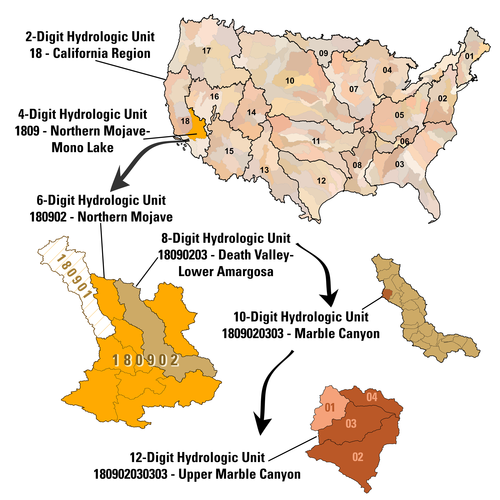

Several Hydroshare resources make up a collection which contains all of the NWM reaches divided up by HUC. This collection was created so that the NWM reaches could be pulled onto web maps via the WMS url that Hydroshare generates for its resources. The entire collection can be found here: https://www.hydroshare.org/resource/c16596e525bf41e2ae843f1e3bbcef90/. 

In [ ]:
# Create a map called 'mappy' with a basemap, and the zoom level and center that we defined previously.
mappy = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)

In [ ]:
# Create a WMS Layer from the desired Hydroshare resource and desired layer (shapefile).
wmslay = WMSLayer(
    url = 'https://geoserver.hydroshare.org/geoserver/HS-f5fa9306f92147918fc500c386cf0dd9/wms?',
    layers = 'HS-f5fa9306f92147918fc500c386cf0dd9:HUC1',
    transparent=True,
    name = 'HUC1',
    format = 'image/png'
)

# Create a layers control at the top right of the map
control = LayersControl(position='topright')

# Add the layers control to 'mappy'
mappy.add_control(control)

# Add the WMS Layer to 'mappy'
mappy.add_layer(wmslay)

mappy

That map shows all of the NWM reaches in HUC1, but we haven't actually done anything which would allow us to get a reach's reach id or view the forecasts yet.

Next we are going to use some Jupyter notebook magic to run HTML and display a JavaScript web map. What you see in the next cell is HTML. All it is really doing is displaying the web page at https://byu-hydroinformatics.github.io/csb-jr233/. 

The web page was built using javascript to display all of the NWM reaches on a map and provide their attributes when features are clicked on. It uses a WMS layer (separate from the ones mentioned above) which contains all of the NWM Reaches and is built using OpenLayers which is a JavaScript library for mapping. 

Zooming into a specific part of the map will prompt the reaches to appear. By clicking on a specific reach you can then obtain its reach id. Be careful, the reach id in this dataset is called a 'station_id'. If you accidentally enter in another value or identifier as your reach id further down, the successive code cells won't work.

The source code for this map and web page can be found here: https://github.com/BYU-Hydroinformatics/NWMReachMap_NWMNotebook2. It consists of several files of code, but the important stuff is primarily in the main.js file. In less than 100 lines of code you could create a similar map yourself!

In [ ]:
%%HTML
<html>
<head></head>
<body>
<iframe title="NWM Reaches" src="https://byu-hydroinformatics.github.io/csb-jr233/" width=100% height=640>
</iframe>
</body>
</html>

After you've had a chance to play around and obtain an object id for a stream of interest, run the next cell and enter in the reach id (station_id) when prompted. <strong>Make sure you are getting the 'station_id' value and not the 'OBJECTID'.</strong>

In [ ]:
# Running this cell will prompt the user to enter in a value which will then be assigned to the variable 'reach'
reach = input("Reach/Stream/Feature ID: ")

In [ ]:
# Convert 'reach' from string type to integer type
reach = int(reach)

In [ ]:
# Here we use ipywidgets to create a menu dropdown with options for the NWM forecast types.
menu = widgets.Dropdown(
       options=['short_range', 'medium_range', 'long_range'],
       value='short_range',
       description='Forecast:')

In [ ]:
# This cell will display the menu that we created in the last cell. Select your desired forecast from it.
menu

In [ ]:
# Now lets build a time series for the reach you entered and the forecast type selected from 'menu'.
Series = GetSeries(reach, today, '00', menu.value, '1')
print(Series)

In [ ]:
# Now lets create a plot of the forecast like we did in the first NWM Notebook.
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Series, color='tab:blue', label='Streamflow')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Flowrate (cms)')
ax.set_title(menu.value + ' forecast for Stream ID ' + str(reach))
ax.grid(True)

Pretty cool right! We can build a map to display the NWM network, display the map here in our Jupyter notebook, obtain a reach id from it, and then plot its forecast!

In [ ]:
files = [f for f in os.listdir('.') 
         if os.path.isfile(f)]

for f in files:
    # Delete leftover netcdf files 
    if "nwm" in f and f.endswith(".conus.nc"):
        print(f)
        os.remove(f)

<em><h4>Exercises</h4></em>

The last part of this notebook asks you to try a few things for yourself. Do your best to complete the 4 exercises below or answer the given questions by using what you've learned here. Feel free to add new cells to run any code that you might need to answer a question or complete a task. It may also be a good idea to run the previous cell after each exercise to delete excess files so that your Jupyter notebook's file browser doesn't fill up. 
1. Extract the river velocity values as a DataArray from the xarray Dataset that we used earlier. What units are these values in? Which reach id corresponds to the largest velocity in the array?

2. You may have noticed that each feature or reach in the NWM has a variety of metadata attributes including one called StreamOrder. There are several methods for assigning stream order. You can read about two of them at this link: https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-stream-order-works.htm. Now try to determine which method the NWM uses to order its streams by interacting with the JavaScript map above. Is it the Strahler or the Shreve method? 

3. Create an ipyleaflet map which displays all of the NWM reaches in Hydrologic Unit Code 2. The shapefile for HUC2 is located in the same resource as HUC1. Also change the zoom level and latitude and longitude coordinates for the center of the map so that the reaches in HUC2 are centered and zoomed in upon. You should be able to do this by editing the code for the ipyleaflet WMS map above (not the JavaScript map). It should wind up looking something like this: 

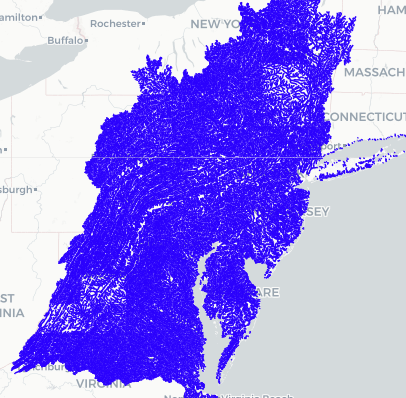

4. Using the NWM JavaScript map above, obtain reach ids for a stream of stream order 2, a stream of stream order 5, and a stream of stream order 8. Try to pick streams that are relatively close to each other if possible. Build a time series for each stream's short range forecast from yesterday using the functions in this notebook. Find the high flow for each of the 3 streams in its respective short range time series and compare. Do your results make sense? Do the higher order streams have larger high flows? What is the reach id of the stream with the highest flow and what stream order does it belong to? Where would you expect to find that reach or stream? HINT: When building the time series, make sure that you've formatted the forecast start date like this: "YYYYMMDD" and the reach ids like this: ########. In other words, the forecast start date should be a string and the reach ids should be integers.

Thank you for using this resource! Hopefully it has helped open your eyes to what can be done to analyze NWM forecasts and create maps and plots of the NWM network.